# 07. Using a Trajectory instead of HOOMD simulation

In [1]:
# (Optional) This block is to surpress the warning on loading tensorflow package
import warnings
warnings.filterwarnings('ignore')

In [2]:
import hoomd
import hoomd.htf as htf
import tensorflow as tf
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt

In [3]:
graph = htf.graph_builder(128)
nlist = graph.nlist[:, :, :3]
r = tf.norm(nlist, axis=2)
# compute 1 / r while safely treating r = 0.
# pairwise energy. Double count -> divide by 2
inv_r6 = graph.safe_div(1., r**6)
p_energy = 4.0 / 2.0 * (inv_r6 * inv_r6 - inv_r6)
# sum over pairwise energy
energy = tf.reduce_sum(p_energy, axis=1)
forces = graph.compute_forces(energy)
# For reference, type indices in this case are: {C:0, H:1, N:2, O:3} 
# compute C-N RDF
rdf = graph.compute_rdf([3, 20], 'rdf-CH', 15, 3, 1)
graph.running_mean(rdf, 'avg-CH')
# compute N-O RDF
rdf2 = graph.compute_rdf([3, 20], 'rdf-OH', 15, 3, 1)
graph.running_mean(rdf2, 'avg-OH')
# save the graph
graph.save(force_tensor=forces, model_directory='traj_model')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Note: Backed-up traj_model previous model to traj_model/previous_model_10



In [4]:
universe = mda.Universe('test_topol.pdb', 'test_traj.trr')
# # Select atom group to use in the system
# atom_group = universe.select_atoms('all')
# # get unique atom types in the selected atom group
# types = list(np.unique(atom_group.atoms.types))
# type_array = np.array([types.index(i)
#                        for i in atom_group.atoms.types]).reshape(-1, 1)

In [5]:
# load graph that calculates RDF
htf.run_from_trajectory('traj_model', universe, period=1, r_cut=25.)







Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Restoring parameters from traj_model/model-5


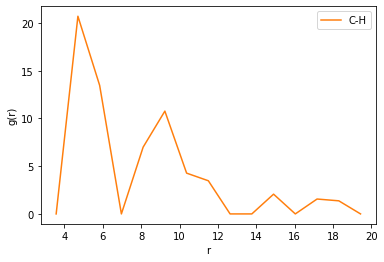

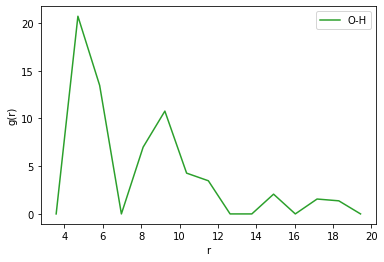

In [6]:
# get evaluated outnodes
variables = hoomd.htf.load_variables('traj_model', ['avg-CH', 'rdf-CH-r', 'avg-OH', 'rdf-OH-r'])

# Plot C-N rdf
r_CH = variables['rdf-CH-r']
# make it go to 1, since htf does not normalize the RDF
rdf_CH = variables['avg-CH']
rdf_CH /= np.mean(rdf_CH[-5:])

plt.figure()
plt.plot(r_CH, rdf_CH, label='C-H', color='C1')
plt.xlabel(r'r')
plt.ylabel(r'g(r)')
plt.legend()
plt.show()

# Plot N-O rdf
r_OH = variables['rdf-OH-r']
rdf_OH = variables['avg-OH']
rdf_OH /= np.mean(rdf_OH[-5:])

plt.figure()
plt.plot(r_OH, rdf_OH, label='O-H', color='C2')
plt.xlabel(r'r')
plt.ylabel(r'g(r)')
plt.legend()
plt.show()